In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

# Previous version (only protein emb, DNA LM data and sequence features used)
- seq_feats
- lm_3utr_emb
- lm_5utr_emb
- prot_emb

In [198]:
# DNA LM embeddings
#dnalm_df = pd.read_parquet('/s/project/multispecies/fungi_code/motif_discovery_pipeline/data/embeddings_non_sac_upstream/Saccharomyces_cerevisiae_BY4741/sequence_features_and_embeddings_Saccharomyces_cerevisiae_BY4741.parquet')
dnalm_df = pd.read_parquet('Data/dnalm_df.parquet')
dnalm_df.head()

,gene_id,embedding_upstream,embedding_downstream,five_prime_seq,cds,three_prime_seq,gc_5_prime,gc_3_prime,gc_cds,AAA,...,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT,species
0,YAL002W,"[0.08123832, 0.030906273, 0.014586483, -0.0152...","[-0.02917197, 0.078893326, -0.05454025, 0.1706...",TTCCAAGGCCGATGAATTCGACTCTTTCCCAGCTGCCTCTGCTGCC...,ATGGAGCAAAATGGCCTTGACCACGACAGCAGATCTAGCATCGATA...,TAACATTTCTAAATATTTAATACAACTTTGGTTACATAAAAGTAAA...,0.365902,0.310000,0.372057,0.043956,...,0.031397,0.0,0.010989,0.010989,0.009419,0.031397,0.013344,0.032967,0.032967,Saccharomyces_cerevisiae_BY4741
1,YAL003W,"[0.032580532, 0.025513712, -0.031748626, -0.04...","[-0.030835396, -0.072578646, -0.05808209, 0.14...",CTTCATGTCAGCCTGCACTTCTGGGTCGTTGAAGTTTCTACCGATC...,ATGGCATCCACCGATTTCTCCAAGATTGAAACTTTGAAACAATTAA...,TAAAAGGCTTTTTTATAAACTTTTTATAATTAACATTAAAGCAAAA...,0.372881,0.253333,0.448220,0.009709,...,0.029126,0.0,0.000000,0.014563,0.004854,0.014563,0.043689,0.038835,0.004854,Saccharomyces_cerevisiae_BY4741
2,YAL004W,"[0.07244772, -0.004530292, 0.08222245, -0.0672...","[-0.032747507, -0.1945743, -0.083140165, 0.042...",CCAATTTGTCACCAGCTTCAGAAATGGTGTTCTTCAAAGAGTAAGC...,ATGGGTGTCACCAGCGGTGGCCTTAACTTCAAAGATACCGTCTTCA...,TAAATCAATACCGACAGCTTTTGACATATTATCTGTTATTTACTTG...,0.417747,0.346667,0.451163,0.023256,...,0.018605,0.0,0.000000,0.023256,0.009302,0.000000,0.055814,0.032558,0.000000,Saccharomyces_cerevisiae_BY4741
3,YAL008W,"[0.018979808, 0.34264776, -0.0416448, 0.006748...","[0.0005224135, -0.061880764, -0.061566852, 0.1...",GTGTCCGGGCCTCGCAGGCGTTCTACTAGCAAGACATCCAGTGCGA...,ATGACTTTGGCTTTTAATATGCAACGGTTGGTGTTTCGTAATTTGA...,TGAGCAAGACAAATGACCAGATATAAACGAGGGTTATATTCTTTCG...,0.381854,0.296667,0.388889,0.045455,...,0.020202,0.0,0.000000,0.015152,0.005051,0.055556,0.025253,0.065657,0.040404,Saccharomyces_cerevisiae_BY4741
4,YAL009W,"[-0.009528967, 0.003373141, 0.000113023896, -0...","[-0.01995761, -0.24868764, -0.054501917, 0.086...",CAAGATAATGTCAAAGTTAGTGGTCGTCCTGTGTTTGTAGAATGTG...,ATGGAGCCAGAGAGCATAGGCGATGTGGGGAACCATGCCCAGGATG...,TGAAAGAGTTGGAGGGCTTCTTCCTTCGAATAAGAGGTCATATTTA...,0.368893,0.323333,0.414414,0.042471,...,0.023166,0.0,0.000000,0.023166,0.007722,0.011583,0.027027,0.019305,0.038610,Saccharomyces_cerevisiae_BY4741


In [199]:
# Sequence features -> 6. columndan sona kadar tüm variablelari aliyo
seq_feats = dnalm_df[['gene_id'] + list(dnalm_df.iloc[:, 6:-1].columns)].dropna()
seq_feats.head()
# gc -> guanine-cytosine content

,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,0.006279,0.031397,0.0,0.010989,0.010989,0.009419,0.031397,0.013344,0.032967,0.032967
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,0.000000,0.029126,0.0,0.000000,0.014563,0.004854,0.014563,0.043689,0.038835,0.004854
2,YAL004W,0.417747,0.346667,0.451163,0.023256,0.023256,0.000000,0.046512,0.004651,0.074419,...,0.000000,0.018605,0.0,0.000000,0.023256,0.009302,0.000000,0.055814,0.032558,0.000000
3,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.000000,0.020202,0.0,0.000000,0.015152,0.005051,0.055556,0.025253,0.065657,0.040404
4,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,0.003861,0.023166,0.0,0.000000,0.023166,0.007722,0.011583,0.027027,0.019305,0.038610


In [200]:
# Upstream sequence embedding -> embedding_upstream column unu alip degerleri column olarak yaziyo
# Upstream - something which S depends on
# The embedding_upstream represents features derived from the sequence located before the gene's start codon (5' end).
lm_5utr_emb = pd.DataFrame(np.stack(dnalm_df.dropna().embedding_upstream.values), index=dnalm_df.dropna().gene_id)
lm_5utr_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,0.081238,0.030906,0.014586,-0.015279,0.028113,0.121253,0.068083,0.171768,-0.014086,0.544913,...,-0.030622,-0.045234,-0.263034,0.105608,0.000841,-0.068895,0.092609,0.012248,0.040396,-0.008431
YAL003W,0.032581,0.025514,-0.031749,-0.042321,-0.052058,0.100852,-0.040193,0.227620,-0.041441,0.127843,...,-0.004374,-0.035856,-0.159351,0.127666,0.066430,-0.019931,0.045678,0.022475,-0.025326,-0.090283
YAL004W,0.072448,-0.004530,0.082222,-0.067203,-0.010486,-0.015001,0.229780,0.198991,-0.101902,0.422294,...,-0.029051,-0.134829,-0.129500,0.040292,0.037237,0.001085,0.122111,0.084727,0.389339,0.085969
YAL008W,0.018980,0.342648,-0.041645,0.006749,-0.031477,0.081134,0.195077,0.200070,-0.049627,0.392190,...,0.044176,-0.022111,-0.216389,0.075199,0.044513,-0.020134,0.051188,0.055149,-0.255109,-0.061252
YAL009W,-0.009529,0.003373,0.000113,-0.007516,-0.010976,0.063841,0.181502,0.260650,-0.035609,0.194044,...,-0.007081,0.005693,-0.196746,0.071950,0.073255,0.002211,0.107910,-0.004822,-0.406600,-0.065601


In [201]:
# Downstream sequence embedding -> embedding_downstream column unu alip degerleri column olarak yaziyo
# Downstream - something which depends on S
# The embedding_downstream represents features derived from the sequence located after the gene's stop codon (3' end).
lm_3utr_emb = pd.DataFrame(np.stack(dnalm_df.dropna().embedding_downstream.values), index=dnalm_df.dropna().gene_id)
lm_3utr_emb.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,-0.029172,0.078893,-0.054540,0.170680,-0.107067,-0.092142,0.094663,-0.073110,0.010419,0.073653,...,0.078681,0.033648,0.014682,-0.074566,0.052284,0.034215,0.132639,0.110446,-0.013290,0.052378
YAL003W,-0.030835,-0.072579,-0.058082,0.145516,0.149264,-0.134691,0.159887,-0.117146,0.021611,0.060180,...,0.033926,0.019848,-0.004159,-0.071930,0.093962,-0.118783,0.159958,0.053212,-0.016180,-0.016293
YAL004W,-0.032748,-0.194574,-0.083140,0.042409,-0.167408,-0.126880,0.001361,-0.057888,0.031826,0.058797,...,0.064126,0.029112,-0.026013,-0.039213,0.102791,-0.111031,0.153221,0.017565,0.043769,0.003665
YAL008W,0.000522,-0.061881,-0.061567,0.106177,0.190146,-0.093892,0.050411,-0.155466,-0.009316,-0.006226,...,0.088757,0.043351,-0.037464,-0.073037,0.038244,-0.024653,-0.003237,0.044000,0.024346,0.006319
YAL009W,-0.019958,-0.248688,-0.054502,0.086972,0.208853,0.028963,-0.019007,-0.138868,-0.011246,0.009775,...,0.073859,0.001456,-0.025106,-0.022704,0.054237,-0.049160,-0.003523,0.056109,-0.006815,0.032631


In [202]:
# Protein embeddings from ESM2 -> The ESM-2 model is a transformer-based protein language model that was pretrained on masked language model (MLM) task
#dataset = pd.read_pickle("/s/project/semi_supervised_multispecies/Downstream/Sequences/Annotation/Sequences/saccharomyces_cerevisiae/all_w_protein_seqs_embs.pickle")
#prot_emb = pd.DataFrame(np.stack(dataset.protein_emb.dropna().values), index=dataset.gene_id)
prot_emb = pd.read_parquet('Data/protein_emb.parquet')
prot_emb.tail()

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
gene_id,,,,,,,,,,,,,,,,,,,,,
YPL199C,0.050171,-0.124207,-0.000984,0.062805,-0.088562,-0.036316,0.031158,-0.106934,-0.031799,0.085876,...,0.071045,-0.048981,-0.098572,0.004658,0.009132,-0.137817,0.017197,-0.145996,0.059937,0.136597
YPL259C,-0.041290,0.042664,-0.018112,0.002455,-0.123901,-0.114624,0.030167,-0.141479,-0.130737,-0.037384,...,0.040649,-0.039062,-0.057220,0.024551,0.001283,-0.014725,0.142578,-0.138184,0.030472,0.016068
YPR179C,0.020782,-0.054382,0.030899,0.098206,-0.061951,-0.054840,-0.000657,0.010979,0.000120,0.012947,...,0.108215,-0.002256,-0.048828,0.029190,-0.015007,-0.015533,-0.013390,-0.111938,0.034851,0.014557
YPR096C,0.106873,-0.009323,-0.022049,0.028442,-0.068481,-0.003551,-0.061035,0.142700,0.149780,0.111328,...,0.185669,0.034546,-0.067688,0.184570,-0.008293,0.144897,0.011856,0.093933,-0.090149,0.051788
YPL174C,0.037201,-0.047119,0.057404,0.012878,-0.039001,-0.095581,0.004456,0.042480,0.035767,-0.035248,...,0.140503,0.048126,-0.018814,0.015976,-0.031036,-0.038940,0.018814,-0.058868,-0.006973,0.000733


In [203]:
def zscore_matrix(mat):

    m = np.mean(np.array(mat, dtype=np.float32).flatten())
    sd = np.std(np.array(mat, dtype=np.float32).flatten())

    mat_z = (mat - m)/sd
    return mat_z

In [204]:
%%time

seq_feats = seq_feats.set_index('gene_id')
# seq_feats_z = zscore_matrix(seq_feats)
# seq_feats_z = seq_feats_z.reset_index()

prot_emb_z = zscore_matrix(prot_emb)
prot_emb_z.columns = prot_emb_z.columns.astype(str)
prot_emb_z.columns = 'ESM2_' + prot_emb_z.columns
prot_emb_z = prot_emb_z.reset_index()

lm_3utr_emb_z = zscore_matrix(lm_3utr_emb)
lm_3utr_emb_z.columns = lm_3utr_emb_z.columns.astype(str)
lm_3utr_emb_z.columns = 'LM_3UTR_' + lm_3utr_emb_z.columns
lm_3utr_emb_z = lm_3utr_emb_z.reset_index()

lm_5utr_emb_z = zscore_matrix(lm_5utr_emb)
lm_5utr_emb_z.columns = lm_5utr_emb_z.columns.astype(str)
lm_5utr_emb_z.columns = 'LM_5UTR_' + lm_5utr_emb_z.columns
lm_5utr_emb_z = lm_5utr_emb_z.reset_index()

# Merge all the embeddings to get a per gene S.cerevisiae embedding
yeast_emb_full = seq_feats.merge(prot_emb_z, on='gene_id').merge(lm_3utr_emb_z, on='gene_id').merge(lm_5utr_emb_z, on='gene_id')
yeast_emb_full



CPU times: user 144 ms, sys: 42 ms, total: 186 ms
Wall time: 190 ms


,gene_id,gc_5_prime,gc_3_prime,gc_cds,AAA,AAC,AAG,AAT,ACA,ACC,...,LM_5UTR_758,LM_5UTR_759,LM_5UTR_760,LM_5UTR_761,LM_5UTR_762,LM_5UTR_763,LM_5UTR_764,LM_5UTR_765,LM_5UTR_766,LM_5UTR_767
0,YAL002W,0.365902,0.310000,0.372057,0.043956,0.019623,0.018053,0.039246,0.013344,0.007849,...,-0.078495,-0.101951,-0.451596,0.140201,-0.027987,-0.139936,0.119334,-0.009675,0.035513,-0.042870
1,YAL003W,0.372881,0.253333,0.448220,0.009709,0.024272,0.077670,0.004854,0.000000,0.019417,...,-0.036358,-0.086898,-0.285149,0.175611,0.077306,-0.061331,0.043992,0.006744,-0.069993,-0.174272
2,YAL004W,0.417747,0.346667,0.451163,0.023256,0.023256,0.000000,0.046512,0.004651,0.074419,...,-0.075972,-0.245783,-0.237227,0.035347,0.030442,-0.027595,0.166694,0.106680,0.595686,0.108673
3,YAL008W,0.381854,0.296667,0.388889,0.045455,0.020202,0.040404,0.050505,0.015152,0.005051,...,0.041582,-0.064832,-0.376715,0.091384,0.042122,-0.061658,0.052838,0.059197,-0.438873,-0.127666
4,YAL009W,0.368893,0.323333,0.414414,0.042471,0.011583,0.023166,0.027027,0.011583,0.007722,...,-0.040703,-0.020197,-0.345180,0.086169,0.088264,-0.025787,0.143896,-0.037077,-0.682068,-0.134648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6574,YPR195C,0.334995,0.393333,0.467890,0.027523,0.000000,0.000000,0.027523,0.045872,0.009174,...,-0.069516,-0.091421,-0.402476,0.095457,0.023955,-0.072979,-0.082304,0.072628,-0.665834,0.037950
6575,YPR197C,0.376869,0.276667,0.374332,0.058824,0.021390,0.021390,0.016043,0.042781,0.005348,...,-0.014195,-0.102008,-0.424302,0.133435,0.087042,-0.024667,0.205772,0.009731,-0.687237,0.048592
6576,YPR199C,0.329013,0.283333,0.391156,0.030612,0.020408,0.047619,0.047619,0.027211,0.003401,...,0.052901,-0.037409,-0.385326,0.083647,0.060815,-0.034371,0.054171,0.069161,-0.484573,-0.094109
6577,YPR200C,0.366899,0.313333,0.376923,0.038462,0.015385,0.038462,0.023077,0.030769,0.015385,...,0.087128,-0.082817,-0.418286,0.099563,0.080339,-0.000032,0.105696,0.047736,-0.490977,0.055293


0.8445407769173735


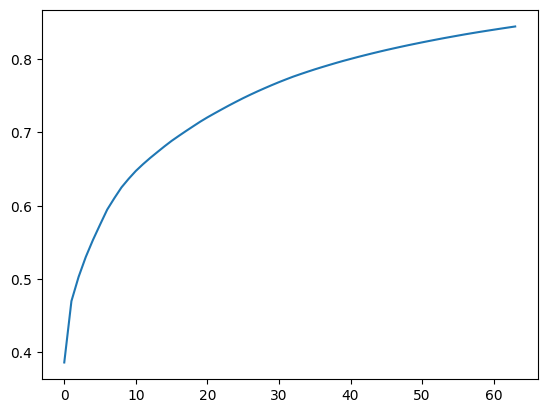

In [205]:
# Check what is the percentage of the variance explained by compressed data compared to the full data
N=64
pca = PCA(n_components=N)
pca.fit_transform(yeast_emb_full.iloc[:,1:])
ev = pca.explained_variance_ratio_.cumsum()
print(ev[-1])
plt.plot(range(0, N), ev)

In [206]:
dims = 64
emb_full_pca = pd.DataFrame(PCA(n_components=dims).fit_transform(yeast_emb_full.iloc[:,1:]), index=yeast_emb_full.gene_id).reset_index()
emb_full_pca

,gene_id,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,YAL002W,1.350518,-2.705953,-1.249147,-0.884463,0.093777,-3.918616,-1.101292,-0.525820,-0.365258,...,-0.368649,0.200829,0.097486,-0.089653,0.500969,-0.160314,0.343798,0.647995,-0.109918,-0.028233
1,YAL003W,7.801300,-1.138063,-0.104988,-1.874635,0.463608,4.607939,-0.764479,-2.198857,-1.092609,...,-0.136071,0.901259,-0.073821,-0.270436,-0.568851,0.406562,0.605340,-0.327467,1.045534,-1.074026
2,YAL004W,-8.824801,5.049178,4.525735,-1.249379,-0.547005,0.965001,0.615475,0.441012,-0.987946,...,-0.951635,-0.177627,0.287404,-0.745287,-0.408976,0.557414,1.646664,-0.537666,-0.296406,-1.583358
3,YAL008W,1.003984,-4.439332,-2.055461,-2.095814,-0.039439,-0.533439,-2.068278,-1.012841,-2.278583,...,0.064140,-0.241661,-0.102371,-0.317495,-0.233894,-0.093701,0.466710,-0.364993,-0.179689,-0.539659
4,YAL009W,0.317848,-2.682067,-1.796905,-0.984867,-0.965357,1.003266,-0.912031,1.055314,-0.916025,...,-0.263347,0.594560,0.191713,-0.269394,0.516120,0.436699,-0.345001,-0.470964,-0.273599,-0.218154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6574,YPR195C,-12.959321,2.593324,-2.731855,1.928469,-0.405484,2.816277,1.141237,1.486669,-1.403696,...,0.722671,-0.026188,1.375869,-0.580314,0.043321,-0.303992,-0.258775,0.338863,-0.254895,-0.224385
6575,YPR197C,-10.684675,8.455941,6.477363,-4.848729,-0.594108,2.483717,-3.985001,-2.043341,3.759298,...,1.095506,0.994979,-0.774412,-0.071136,0.996470,1.489584,0.844723,-0.129451,-0.665354,-0.406095
6576,YPR199C,-4.017440,-2.991633,0.940513,0.920400,0.986334,0.223407,-2.316896,0.581107,1.129787,...,0.026815,-0.078545,0.208443,-0.101216,-0.248171,0.429555,0.672684,0.345528,0.734356,-0.027320
6577,YPR200C,4.573682,-0.580103,-2.770326,-1.135877,0.678429,0.205747,-1.006403,-0.226968,0.700998,...,-0.160617,0.368695,-0.634610,-0.078365,-0.303498,0.770957,0.182066,-0.730802,-0.707516,-0.660188


# Load the data, that is needed to be incorporated as well
- experimental gene-gene interaction by Costazo et al 2016 
- gene expression and fitness data
- Yeast Net

In [207]:
# Gene expression and fitness data
data_experiment_decriptions= pd.read_csv('Data/yp_screens_haphom_20221025.txt', sep = '\t', index_col = 0)
data_Turco = pd.read_csv('Data/yp_matrix_z_haphom_20221025.txt', sep = '\t', index_col = 0)

In [208]:
# not sure how to incorporate this data
data_experiment_decriptions

,name,collection,phenotype,conditionset,medium,paper,pmid,latest_tested_status,num_tested
id,,,,,,,,,
1,hap a | growth (streaks on agar) | rapamycin [...,hap a,growth (streaks on agar),rapamycin [25 nM],YPD,"Chan TF~Zheng XF, 2000 - 11078525",11078525,request abandoned,2216
2,hap a | NHEJ | standard | SC - Ura | Ooi SL~Bo...,hap a,NHEJ,standard,SC - Ura,"Ooi SL~Boeke JD, 2001 - 11701889",11701889,request abandoned,4647
4,hap alpha | growth (exponential growth rate) |...,hap alpha,growth (exponential growth rate),ethanol [8%],YPD,"Yoshikawa K~Shimizu H, 2009 - 19054128",19054128,loaded,4729
5,hap alpha | growth (exponential growth rate) |...,hap alpha,growth (exponential growth rate),sodium chloride [1 M],YPD,"Yoshikawa K~Shimizu H, 2009 - 19054128",19054128,loaded,4729
7,hap a | growth (colony size) | streptomycin [4...,hap a,growth (colony size),streptomycin [40 mg/ml],SC,"Alamgir M~Golshani A, 2010 - 20691087",20691087,loaded,4669
...,...,...,...,...,...,...,...,...,...
22217,"hom | growth (pooled culture, barseq) | gadoli...",hom,"growth (pooled culture, barseq)","gadolinium [IC20], time [15 gen]",YPD,"Pallares RM~Abergel RJ, 2022 - 35040455",35040455,loaded,4291
22218,hap a | protein transport to the vacuole (Sec6...,hap a,protein transport to the vacuole (Sec61-mCherr...,rapamycin [200 ug/L],SC - Leu,"Chen S~Ferro-Novick S, 2020 - 32690699",32690699,request abandoned,0
22219,hap a | mating creep | opposite mating type st...,hap a,mating creep,opposite mating type strain [MAT alpha (BY4742)],YPD,"Arras SDM~Ganley ARD, 2022 - 35298616",35298616,loaded,4929


In [209]:
# add gene_id as index
data_Turco.index.name = "gene_id"  
data_Turco


,1,2,4,5,7,8,9,10,11,14,...,22212,22213,22214,22215,22216,22217,22218,22219,22220,22228
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,-0.071896,0.0,-0.351851,-0.272362,0.021981,-0.672391,-0.243525,-0.291566,-2.623798,1.015551,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,-8.335666,0.0,NaN,-1.692692
YAL005C,-0.071896,0.0,-0.539305,-0.282393,-0.237616,-0.290585,-0.134638,0.249022,NaN,-0.984568,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,NaN,-2.003358
YAL007C,-0.071896,0.0,-0.316477,-1.716964,0.669387,0.352375,0.557858,0.136025,1.104770,-0.291439,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,NaN,-1.374965
YAL008W,-0.071896,0.0,-0.247000,-0.095510,1.414719,0.122065,-0.573721,-1.002780,0.211580,0.262476,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-8.079187,0.000000,0.0,NaN,0.640416
YAL009W,-4.817055,0.0,-2.212226,-1.010491,-0.250085,-0.016314,-0.030528,-0.013983,0.233321,NaN,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR196W,-0.071896,0.0,-0.320923,-0.872477,1.552995,-0.010449,-0.140292,-1.044475,-0.102829,-0.233030,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,-1.337041,-0.130582
YPR198W,-0.071896,0.0,-0.705077,-0.958221,0.799231,0.193457,0.143067,1.181440,0.186180,-0.443869,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,-0.492903,-1.622164
YPR199C,-0.071896,0.0,-0.228440,-0.432992,0.423262,-0.940111,3.520616,0.321456,-0.192618,-0.308187,...,0.013849,-0.089649,-0.030395,-0.059043,-0.006962,-0.078004,0.000000,0.0,-0.047430,1.573639


In [210]:
# Gene-gene interactions, they need to be combined, cause separatedly for essential and non-essential genes
GxG_data_Costanzo_ExE = pd.read_csv('Data/SGA_ExE_clustered.cdt', sep = '\t', dtype = 'str')
GxG_data_Costanzo_ExN = pd.read_csv('Data/SGA_ExN_clustered.cdt', sep = '\t', dtype = 'str')
GxG_data_Costanzo_NxN = pd.read_csv('Data/SGA_NxN_clustered.cdt', sep = '\t', dtype = 'str')

# -> Tyramide Signal Amplification (TSA) is an immunohistochemistry technique designed to detect and quantify molecules such as proteins and nucleic acids.

In [211]:
GxG_data_Costanzo_ExE

,GID,Strain,ORF,Name,Label,GWEIGHT,tsa1184,tsa1067,tsa1100,tsa1111,...,tsa950,tsa367,tsa676,tsa859,tsa860,tsa989,tsa1034,tsa927,tsa1239,tsa932
0,AID,NaN,NaN,NaN,NaN,NaN,ARRY154X,ARRY47X,ARRY76X,ARRY87X,...,ARRY759X,ARRY405X,ARRY594X,ARRY697X,ARRY699X,ARRY777X,ARRY20X,ARRY742X,ARRY202X,ARRY745X
1,ORF,NaN,NaN,NaN,NaN,NaN,YDR478W,YHR040W,YIL104C,YDR064W,...,YBL034C,YBR055C,YLR105C,YDL103C,YDL103C,YKL104C,YKL024C,YOR074C,YDR081C,YOR204W
2,Name,NaN,NaN,NaN,NaN,NaN,SNM1,BCD1,SHQ1,RPS13,...,STU1,PRP6,SEN2,QRI1,QRI1,GFA1,URA6,CDC21,PDC2,DED1
3,Label,NaN,NaN,NaN,NaN,NaN,snm1-5001,bcd1-5001,shq1-5001,rps13-5001,...,stu1-7,prp6-ts,sen2-1,qri1-ts1,qri1-ts6,gfa1-97,ura6-6,cdc21-1,pdc2-5001,ded1-f144c
4,EWEIGHT,NaN,NaN,NaN,NaN,NaN,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,GENE519X,tsq26,YAL038W,CDC19,cdc19-1,1,0.041,0.028,0.042,0.006,...,-0.022,-0.005,-0.021,0.022,-0.004,0.017,0.027,-0.161,0.063,-0.028
825,GENE604X,tsq455,YBR055C,PRP6,prp6-1,1,0.024,-0.046,0.049,0.006,...,NaN,NaN,-0.003,0.004,0.048,0.036,0.067,0.099,0.054,0.016
826,GENE614X,tsq472,YGR091W,PRP31,prp31-1,1,0.058,0.067,0.019,-0.007,...,-0.043,-0.011,0.022,0.014,0.020,0.023,0.060,0.055,0.113,0.043
827,GENE721X,tsq676,YLR105C,SEN2,sen2-1,1,0.018,0.020,0.031,0.004,...,-0.069,-0.007,NaN,0.039,0.004,0.037,0.012,0.093,0.123,0.043


In [212]:
GxG_data_Costanzo_ExE["GID"].head(20)

0          AID
1          ORF
2         Name
3        Label
4      EWEIGHT
5       GENE6X
6     GENE158X
7      GENE47X
8     GENE324X
9     GENE185X
10     GENE98X
11     GENE82X
12    GENE244X
13    GENE189X
14    GENE239X
15     GENE13X
16    GENE589X
17     GENE94X
18    GENE194X
19    GENE254X
Name: GID, dtype: object

In [213]:
GxG_data_Costanzo_ExN

,GID,Strain,ORF,Name,Label,GWEIGHT,dma3509,dma3243,dma3812,dma3908,...,dma750,dma3957,dma2604,dma998,dma4951,dma826,dma4263,dma4575,dma5223,dma615
0,AID,NaN,NaN,NaN,NaN,NaN,ARRY2010X,ARRY1794X,ARRY2271X,ARRY2338X,...,ARRY3621X,ARRY2368X,ARRY1268X,ARRY3825X,ARRY3104X,ARRY3675X,ARRY2508X,ARRY2790X,ARRY3328X,ARRY3507X
1,ORF,NaN,NaN,NaN,NaN,NaN,YML003W,YLR182W,YMR215W,YMR305C,...,YDL180W,YNL027W,YJL204C,YDR251W,YPL220W,YDL234C,YNR062C,YOR182C,YDR036C,YDL018C
2,Name,NaN,NaN,NaN,NaN,NaN,NaN,SWI6,GAS3,SCW10,...,NaN,CRZ1,RCY1,PAM1,RPL1A,GYP7,NaN,RPS30B,EHD3,ERP3
3,Label,NaN,NaN,NaN,NaN,NaN,yml003w,swi6,gas3,scw10,...,ydl180w,crz1,rcy1,pam1,rpl1a,gyp7,ynr062c,rps30b,ehd3,erp3
4,EWEIGHT,NaN,NaN,NaN,NaN,NaN,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2063,GENE1056X,sn543,YKL176C,LST4,lst4,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2064,GENE20X,sn1089,YGR163W,GTR2,gtr2,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2065,GENE2043X,tsq955,YLR321C,SFH1,sfh1-1,1,0.001,NaN,-0.005,0.013,...,0.007,0.038,-0.019,0.028,-0.012,-0.025,0.012,0.189,-0.038,0.003
2066,GENE1057X,sn544,YGR057C,LST7,lst7,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [214]:
GxG_data_Costanzo_NxN

,GID,Strain,ORF,Name,Label,GWEIGHT,dma1902,dma1903,dma3438,dma366,...,dma4474,dma3868,dma3921,dma3907,dma3910,dma3911,dma3918,dma4686,dma4867,dma5251
0,AID,NaN,NaN,NaN,NaN,NaN,ARRY690X,ARRY691X,ARRY1965X,ARRY2138X,...,ARRY2701X,ARRY2300X,ARRY2348X,ARRY2337X,ARRY2340X,ARRY2341X,ARRY2345X,ARRY2876X,ARRY3038X,ARRY3347X
1,ORF,NaN,NaN,NaN,NaN,NaN,YGR152C,YGR151C,YLR408C,YBR219C,...,YOR042W,YMR265C,YMR316C-B,YMR306C-A,YMR304C-A,YMR303C,YMR318C,YOR296W,YPL133C,YCR107W
2,Name,NaN,NaN,NaN,NaN,NaN,RSR1,NaN,BLS1,NaN,...,CUE5,NaN,NaN,NaN,NaN,ADH2,ADH6,NaN,RDS2,AAD3
3,Label,NaN,NaN,NaN,NaN,NaN,rsr1,ygr151c,bls1,ybr219c,...,cue5,ymr265c,ymr316c-b,ymr306c-a,ymr304c-a,adh2,adh6,yor296w,rds2,aad3
4,EWEIGHT,NaN,NaN,NaN,NaN,NaN,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3283,GENE3020X,sn672,YGR041W,BUD9,bud9,1,NaN,NaN,0.059,0.043,...,-0.005,0.002,0.030,0.040,-0.021,-0.004,0.079,0.011,0.044,0.007
3284,GENE3044X,sn701,YLR020C,YEH2,yeh2,1,0.002,0.050,-0.005,-0.012,...,-0.004,0.036,-0.000,0.009,0.105,0.056,0.135,-0.001,0.052,0.005
3285,GENE3143X,sn825,YKR102W,FLO10,flo10,1,-0.022,-0.060,-0.011,-0.044,...,0.048,0.019,0.006,0.026,0.001,0.053,0.102,-0.081,0.018,-0.011
3286,GENE3052X,sn711,YBL043W,ECM13,ecm13,1,-0.059,0.006,-0.199,-0.035,...,0.001,0.029,-0.040,0.002,-0.004,-0.006,0.001,0.006,0.043,-0.019


In [215]:
# Yeast Net data
YeastNetdata = pd.read_csv('Data/YeastNet.csv', sep = ',', index_col = 0)

In [216]:
YeastNetdata.head()

,gene1,gene2,edge_value
0,YBL039C,YGR103W,3.713364
1,YDL060W,YDR101C,3.701611
2,YDL060W,YNL248C,3.693862
3,YDR101C,YOR004W,3.665467
4,YDL148C,YNL062C,3.660805


In [217]:
# Extract the ORF column from the first table
orf_list = GxG_data_Costanzo_ExE["ORF"].dropna().unique()

# Filter rows in the second table where gene1 or gene2 matches the ORF
matching_genes = YeastNetdata[
    (YeastNetdata["gene1"].isin(orf_list)) | (YeastNetdata["gene2"].isin(orf_list))
]

# Extract unique matching gene names
unique_matching_genes = pd.unique(matching_genes[["gene1", "gene2"]].values.ravel())

len(unique_matching_genes)

5009

In [218]:
node_count = len(np.unique(np.concatenate([YeastNetdata.gene1, YeastNetdata.gene2])))
print(f"{len(YeastNetdata)/(node_count**2) * 100} % edges")

0.7386006109725306 % edges


In [219]:
YeastNetdata.to_csv("Data/YeastNet.edg", sep="\t", columns=["gene1", "gene2", "edge_value"], header=False, index=False)

In [220]:
!pecanpy --input "Data/YeastNet.edg" --output "Data/YeastNetEmbeddings.npz" --mode SparseOTF --weighted

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pecanpy/cli.py:302: UserWarning: When p = 1 and q = 1, it is highly recommended to use PreCompFirstOrder over SparseOTF (current selection). The runtime could be improved greatly with low memory usage.
  check_mode(g, args)
Took 00:00:00.31 to load Graph
Took 00:00:00.00 to pre-compute transition probabilities
Took 00:00:03.42 to generate walks
Took 00:00:04.26 to train embeddings


In [221]:
# Add yeastnet data
yeastnet_embeddings_npz = np.load("Data/YeastNetEmbeddings.npz")
yeastnet_embeddings = pd.DataFrame(np.stack(yeastnet_embeddings_npz["data"]), index=yeastnet_embeddings_npz["IDs"]).add_prefix("yeastnet_")
yeastnet_embeddings

yeastnet_emb_z = zscore_matrix(yeastnet_embeddings)
yeastnet_emb_z.columns = yeastnet_emb_z.columns.astype(str)
yeastnet_emb_z = yeastnet_emb_z.reset_index()
yeastnet_emb_z.rename(columns={'index':'gene_id'}, inplace=True)

# m = np.mean(np.array(yeastnet_emb_z.iloc[:,1:], dtype=np.float32).flatten())
# sd = np.std(np.array(yeastnet_emb_z.iloc[:,1:], dtype=np.float32).flatten())
# print(m, sd)

yeastnet_emb_z

,gene_id,yeastnet_0,yeastnet_1,yeastnet_2,yeastnet_3,yeastnet_4,yeastnet_5,yeastnet_6,yeastnet_7,yeastnet_8,...,yeastnet_118,yeastnet_119,yeastnet_120,yeastnet_121,yeastnet_122,yeastnet_123,yeastnet_124,yeastnet_125,yeastnet_126,yeastnet_127
0,YBR247C,0.423008,0.541772,-0.654006,0.329029,0.220458,-0.764676,0.639962,-0.075188,-0.687603,...,-0.908428,-0.236056,0.858852,0.293083,0.258382,0.499689,0.864425,0.340185,-0.735873,0.317351
1,YBL039C,0.254813,0.102429,-1.453526,0.415181,0.104970,-0.707976,1.263803,-0.709858,-0.077750,...,-0.251969,0.129720,0.196205,0.471953,0.074249,0.058780,0.478446,0.470607,-1.156292,1.084429
2,YDL060W,-0.220054,0.646357,-0.828457,0.545801,0.262068,0.108120,1.036266,-0.042628,0.128563,...,0.139303,0.340483,0.147583,1.059074,0.751372,0.454178,0.226548,0.315131,-0.319945,1.166725
3,YBR142W,0.209709,0.379261,-1.325253,0.229284,0.250104,-0.503137,1.654694,-0.053207,-0.032485,...,0.105210,-0.111387,-0.258238,0.438382,0.308900,0.814152,0.656893,-0.245944,-0.923729,1.044640
4,YAL059W,0.503738,0.278446,-0.943258,0.056984,0.569068,-0.513815,1.382043,0.075074,-0.180414,...,-0.082202,-0.294925,0.190596,-0.190155,0.578405,0.293873,0.618763,0.191727,-1.264118,1.671398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5725,YNL167C,-0.480546,-0.504756,-0.151720,0.149788,-0.040436,0.411639,0.626178,-0.895425,-0.307926,...,0.437863,-0.255348,-0.097372,-0.439634,-0.388021,0.021838,-0.562217,0.740316,0.147600,0.003747
5726,YJL127C,-0.615585,-0.336600,0.296229,-0.136583,-0.190069,0.096319,0.710830,-0.668076,-0.020287,...,0.334760,-0.130033,0.338073,0.079990,-0.177967,0.042684,-0.489474,0.292890,0.460102,-0.156248
5727,YDR040C,-1.299238,-0.431738,0.014905,-0.387179,0.103118,0.455476,0.599488,-0.577276,-0.672137,...,0.210046,-0.241159,-0.101472,-0.052255,-0.436059,0.149873,-0.347656,0.496941,0.672421,0.303411
5728,YOR112W,-0.681854,0.020972,-0.049492,0.041308,-0.038771,0.057788,0.886439,-0.706773,-0.201393,...,0.287050,-0.117677,-0.021337,0.065162,-0.411807,0.289762,-0.364464,0.451179,0.475745,0.176340


In [222]:
# Fixing data_Turco
# data_Turco has 4554 rows

# removes columns with around over > 11% NaN values
data_Turco = data_Turco.loc[:, data_Turco.isna().sum() <= 500]
# now left with 7460 columns

# Fill remaining NaN values with the mean of the column
data_Turco = data_Turco.fillna(data_Turco.mean())

# remove the columns that are filled with > 11% zeros
data_Turco = data_Turco.loc[:, (data_Turco == 0).sum() <= 500]
# now left with 7060 columns

# remove the columns that are filled with > 11% dummy values 
dummy_counts = data_Turco.apply(lambda col: col.value_counts().iloc[0])
data_Turco = data_Turco.loc[:, dummy_counts <= 500]
# now left with 6855 columns

data_Turco



,4,5,7,8,9,10,11,19,20,21,...,22203,22204,22205,22206,22207,22208,22209,22210,22211,22220
gene_id,,,,,,,,,,,,,,,,,,,,,
YAL002W,-0.351851,-0.272362,0.021981,-0.672391,-0.243525,-0.291566,-2.623798,1.408727,0.054675,-0.770475,...,1.391887,-5.588357,1.381455,1.122263,1.731333,-0.982449,0.914764,-2.202816,0.548573,0.471807
YAL005C,-0.539305,-0.282393,-0.237616,-0.290585,-0.134638,0.249022,-0.037406,3.191916,-0.140198,-0.180131,...,-0.902167,-0.499560,1.359727,-0.133503,0.240099,-1.885976,-0.889893,-0.941291,0.711653,0.471807
YAL007C,-0.316477,-1.716964,0.669387,0.352375,0.557858,0.136025,1.104770,0.448274,0.037942,-0.309211,...,0.807585,0.215130,-1.142634,0.444164,-0.044681,-1.729168,-1.014971,0.346001,-0.356431,0.471807
YAL008W,-0.247000,-0.095510,1.414719,0.122065,-0.573721,-1.002780,0.211580,-0.598526,-0.177977,0.188519,...,-0.337381,0.308874,-1.513535,0.717261,-0.900796,-0.052223,0.378941,-0.039288,-0.652139,0.471807
YAL009W,-2.212226,-1.010491,-0.250085,-0.016314,-0.030528,-0.013983,0.233321,0.335025,0.373353,0.797040,...,-0.202027,0.167883,-0.511368,0.091909,0.505866,0.392999,-0.770208,-0.400763,-0.028820,0.471807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YPR196W,-0.320923,-0.872477,1.552995,-0.010449,-0.140292,-1.044475,-0.102829,0.046836,0.386272,0.662955,...,0.519797,-0.047102,0.729972,-0.026526,1.075132,0.544442,-0.059988,-0.264980,1.435348,-1.337041
YPR198W,-0.705077,-0.958221,0.799231,0.193457,0.143067,1.181440,0.186180,-0.206314,0.299998,0.262732,...,-0.205392,0.071726,0.254073,-0.418559,0.038454,-0.113519,-0.199637,-0.038975,-0.628549,-0.492903
YPR199C,-0.228440,-0.432992,0.423262,-0.940111,3.520616,0.321456,-0.192618,-0.492426,0.385488,-0.128425,...,-0.073449,0.173136,-0.058874,-0.081747,-0.401267,-0.671967,0.043434,0.068252,0.817105,-0.047430


In [223]:
# add data Turco
data_Turco_z = zscore_matrix(data_Turco)
data_Turco_z.columns = data_Turco_z.columns.astype(str)
data_Turco_z.columns = 'data_Turco_' + data_Turco_z.columns
data_Turco_z = data_Turco_z.reset_index()

data_Turco_z

,gene_id,data_Turco_4,data_Turco_5,data_Turco_7,data_Turco_8,data_Turco_9,data_Turco_10,data_Turco_11,data_Turco_19,data_Turco_20,...,data_Turco_22203,data_Turco_22204,data_Turco_22205,data_Turco_22206,data_Turco_22207,data_Turco_22208,data_Turco_22209,data_Turco_22210,data_Turco_22211,data_Turco_22220
0,YAL002W,-0.298840,-0.216679,0.087559,-0.630155,-0.186873,-0.236529,-2.647164,1.520924,0.121353,...,1.503518,-5.711384,1.492735,1.224830,1.854375,-0.950637,1.010356,-2.212030,0.631854,0.552508
1,YAL005C,-0.492596,-0.227048,-0.180765,-0.235514,-0.074325,0.322233,0.026176,3.364059,-0.080072,...,-0.867656,-0.451514,1.470277,-0.073152,0.313009,-1.884538,-0.854970,-0.908096,0.800416,0.552508
2,YAL007C,-0.262277,-1.709845,0.756729,0.429060,0.641451,0.205437,1.206748,0.528183,0.104057,...,0.899574,0.287201,-1.116207,0.523935,0.018657,-1.722460,-0.984253,0.422472,-0.303574,0.552508
3,YAL008W,-0.190465,-0.033881,1.527118,0.191008,-0.528169,-0.971652,0.283532,-0.553808,-0.119121,...,-0.283883,0.384096,-1.499577,0.806212,-0.866239,0.010861,0.456519,0.024230,-0.609223,0.552508
4,YAL009W,-2.221756,-0.979622,-0.193654,0.047976,0.033285,0.050386,0.306004,0.411127,0.450743,...,-0.143980,0.238366,-0.463719,0.159838,0.587712,0.471050,-0.731261,-0.349397,0.035050,0.552508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4549,YPR196W,-0.266873,-0.836969,1.670042,0.054039,-0.080169,-1.014748,-0.041447,0.113250,0.464097,...,0.602110,0.016153,0.819351,0.037421,1.176115,0.627584,0.002835,-0.209049,1.548440,-1.317150
4550,YPR198W,-0.663940,-0.925595,0.890938,0.264800,0.212716,1.285996,0.257278,-0.148410,0.374923,...,-0.147458,0.138977,0.327454,-0.367791,0.104585,-0.052496,-0.141509,0.024554,-0.584840,-0.444634
4551,YPR199C,-0.171280,-0.382709,0.502330,-0.906876,3.703809,0.397101,-0.134254,-0.444141,0.463286,...,-0.011079,0.243796,0.003986,-0.019656,-0.349917,-0.629718,0.109733,0.135385,0.909414,0.015814
4552,YPR200C,0.335020,0.206304,0.483500,-0.224025,-0.713399,0.460829,-0.490984,0.063272,0.088699,...,0.050188,0.266027,0.233621,-0.143051,-0.618041,-0.754326,0.095052,0.031864,1.378432,-0.461211


In [224]:
full_with_turco_yeast = yeast_emb_full.merge(data_Turco_z, on='gene_id').merge(yeastnet_emb_z, on='gene_id')

In [225]:
dims = 64
full_turco_yeast_pca = pd.DataFrame(PCA(n_components=dims).fit_transform(full_with_turco_yeast.iloc[:,1:]), index=full_with_turco_yeast.gene_id).reset_index()
full_turco_yeast_pca

,gene_id,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,YAL002W,-22.587612,-21.667216,10.770068,25.801835,-25.319367,20.289377,34.215424,-22.050762,5.393067,...,-1.402755,1.326601,0.274097,-4.726014,7.320366,-7.085216,-2.137692,-5.060844,-0.566624,-10.215399
1,YAL008W,3.141713,6.590012,7.648107,2.651009,11.417904,-5.546382,2.810810,-1.126396,-3.578167,...,0.646712,-2.242087,1.199485,2.394406,-0.226907,0.106037,-0.643679,2.411130,-0.993017,-2.382384
2,YAL009W,-35.673632,-19.573131,11.645597,7.662140,-0.566660,-5.323695,2.788750,-25.268248,10.027739,...,8.025386,-1.701532,7.554582,-15.433054,14.164129,-0.490077,5.841651,-1.877640,-5.293545,3.363566
3,YAL011W,-11.301978,-18.542580,15.227416,13.387801,-17.371417,13.945815,-25.922076,-27.108927,-17.600486,...,1.975709,-9.632877,3.543941,-7.390207,7.636449,8.170907,-8.627914,10.660557,-2.609868,-11.830645
4,YAL012W,-32.471033,-3.867376,16.282039,-7.515336,5.863225,-1.996394,4.621236,8.078282,-5.663476,...,-2.956428,-4.489937,13.314856,16.555575,-7.725848,-7.090913,-1.507535,1.268108,16.953058,8.867430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4432,YPR188C,1.117091,25.674147,1.705473,1.780326,0.947546,-2.391708,0.173382,-2.302196,-1.747849,...,0.015819,0.875838,-1.403143,0.683893,1.704679,-1.399685,-1.727610,1.347064,0.102333,1.258078
4433,YPR193C,4.920260,-3.913804,1.160826,5.099183,1.920900,-7.149663,3.261592,1.433534,-2.635933,...,-2.705701,4.440183,1.280925,0.361180,2.953904,4.292966,1.313530,-2.517964,-0.078468,-1.723639
4434,YPR194C,4.064566,-8.827653,5.723855,4.777688,0.194806,-9.328814,4.043081,0.338530,0.144114,...,-2.423967,0.359865,1.163184,-0.851975,2.994832,-1.426489,-0.108950,0.596579,-0.547143,-1.828362
4435,YPR199C,4.843784,1.873365,-8.843795,0.028694,-4.378742,-3.967431,1.195207,-1.579922,-1.578569,...,-1.541888,1.204496,0.436956,1.145341,1.309467,0.801604,-0.730952,0.192988,2.506437,-0.977989


# Simple evaluation on single mutant fitness data

In [226]:
# Read in single mutant fitness data from Constanzo et al. 2016
smf_filter = pd.read_csv('Data/smf.csv', index_col = 0)
smf_filter

,gene_id,smf_26,smf_26_sd,smf_30,smf_30_sd
0,YAL001C,0.8658,0.0988,0.8285,0.0988
1,YAL002W,0.7640,0.0773,0.7640,0.0773
2,YAL004W,1.0090,0.0227,1.0090,0.0227
3,YAL005C,1.0405,0.0109,1.0405,0.0109
4,YAL007C,1.0260,0.0769,1.0260,0.0769
...,...,...,...,...,...
5843,YPR198W,0.9962,0.1082,0.9962,0.1082
5844,YPR199C,1.0128,0.0649,1.0128,0.0649
5845,YPR200C,1.0457,0.0119,1.0457,0.0119
5846,YPR201W,0.9995,0.1009,0.9995,0.1009


<Axes: >

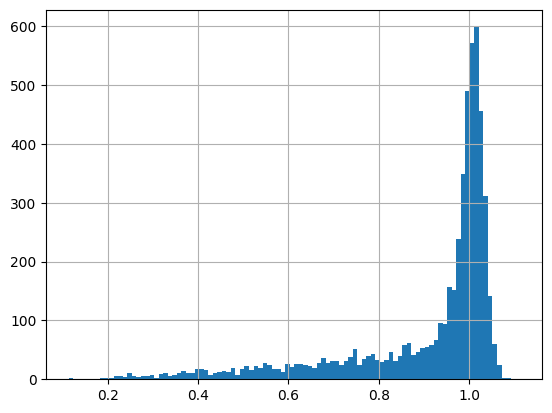

In [227]:
smf_filter.smf_30.hist(bins=100)

In [228]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

R2:  0.495674939743713


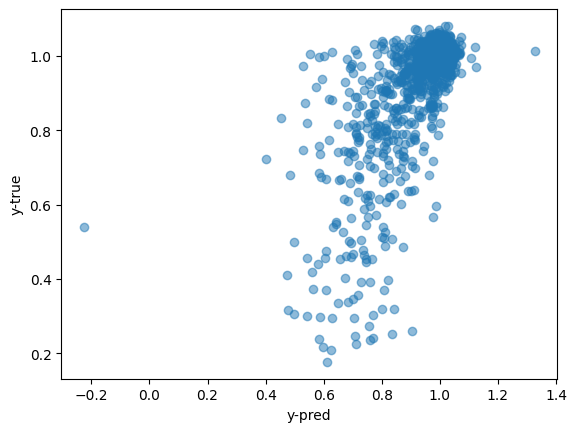

In [230]:
# How predictive are sequence features?

A = smf_filter.merge(full_turco_yeast_pca, on='gene_id').dropna()
X = A.iloc[:, 5:]
y = A['smf_30']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

lm = LinearRegression().fit(X_train, y_train)
print('R2: ', lm.score(X_test, y_test))

plt.scatter(lm.predict(X_test), y_test, alpha=0.5)
plt.xlabel("y-pred")
plt.ylabel("y-true")
plt.show()